> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

We will be accessing files on S3 in this notebook. Since those files are public, we set the `AWS_NO_SIGN_REQUEST` to tell `rasterio` to skip the sign-in.

In [ ]:
%env AWS_NO_SIGN_REQUEST=YES

# Training a model

In [2]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

To keep things simple, we use one scene for training and one for validation. In a real workflow, we would normally use many more scenes.

In [3]:
train_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [4]:
val_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

In [5]:
import albumentations as A

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

In [6]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform,
)
len(train_ds)

2024-04-09 20:16:43:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif.
2024-04-09 20:16:43:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


400

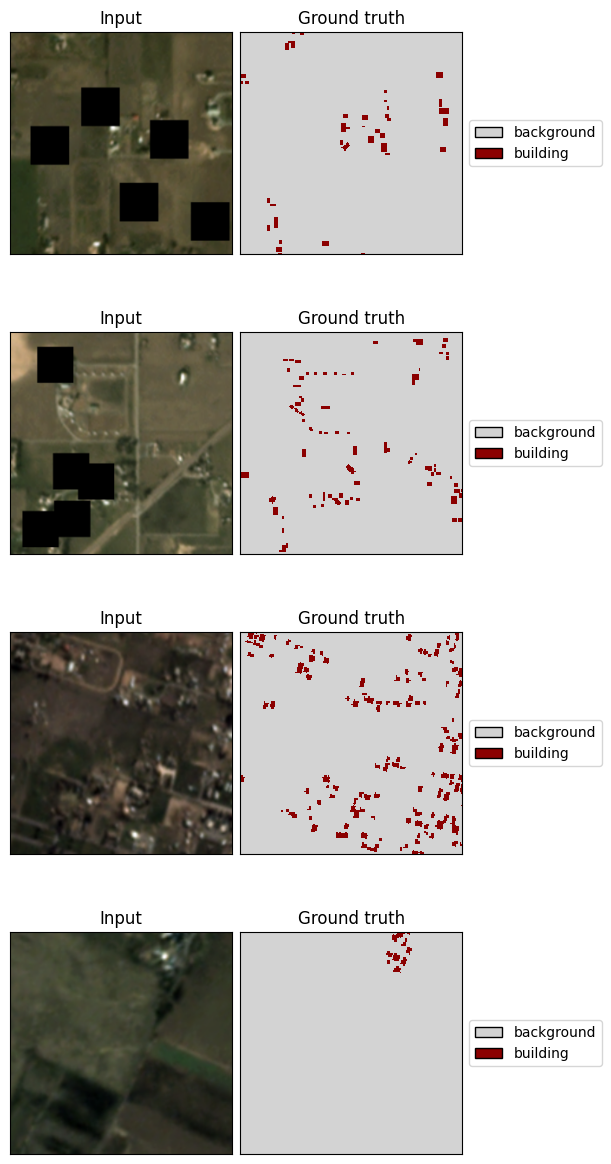

In [8]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

In [7]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=100,
    out_size=256,
)
len(val_ds)

2024-04-09 20:16:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif.
2024-04-09 20:16:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson.


100

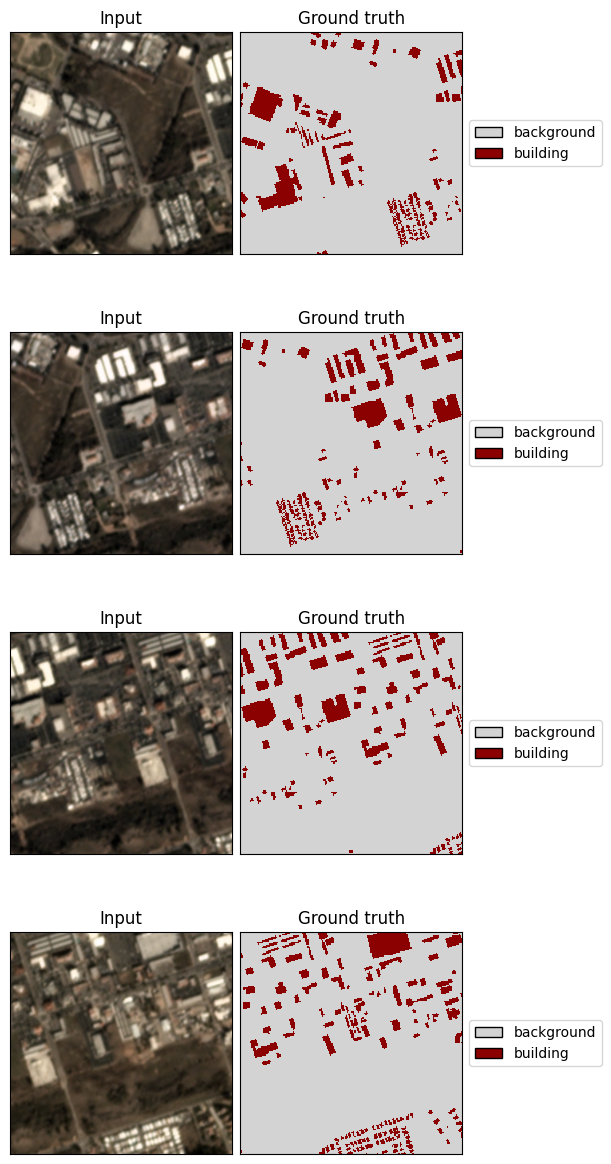

In [10]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

## Define model

Use a [light-weight panoptic FPN model](https://github.com/AdeelH/pytorch-fpn) with a ResNet-18 backbone.

In [ ]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

## Configure the training

In [9]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0, # increase to use multi-processing
)

In [10]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)

In [11]:
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [15]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='data/train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)

2024-04-09 20:18:03:rastervision.pytorch_learner.learner: INFO - Building dataloaders


In [16]:
learner.log_data_stats()

2024-04-09 20:18:03:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2024-04-09 20:18:03:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items


## Run `Tensorboard` for monitoring

In [13]:
%load_ext tensorboard

This will start an instance of tensorboard and embed it in the output of the cell:

In [ ]:
%tensorboard --bind_all --logdir "data/train-demo/tb-logs" --reload_interval 10 

![A screenshot of the Tensorboard dashboard.](../../img/tensorboard.png "A screenshot of the Tensorboard dashboard.")


In [17]:
learner.train(epochs=3)

2024-04-09 20:18:43:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2024-04-09 20:18:43:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items
2024-04-09 20:18:43:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-04-09 20:18:43:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-04-09 20:18:44:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2024-04-09 20:18:49:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.2913476228713989,
 'train_time': '0:00:03.397020',
 'val_loss': 0.3804737329483032,
 'avg_precision': 0.9294803738594055,
 'avg_recall': 0.8374766707420349,
 'avg_f1': 0.8810832500457764,
 'background_precision': 0.9746540188789368,
 'background_recall': 0.8492995500564575,
 'background_f1': 0.9076691269874573,
 'building_precision': 0.21413441002368927,
 'building_recall': 0.6502557396888733,
 'building_f1': 0.3221742510795593,
 'valid_time': '0:00:01.604234'}
2024-04-09 20:18:49:rastervision.pytorch_learner.learner: INFO - epoch: 1


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2024-04-09 20:18:53:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 1,
 'train_loss': 0.24667344987392426,
 'train_time': '0:00:02.883060',
 'val_loss': 0.4013445973396301,
 'avg_precision': 0.927025318145752,
 'avg_recall': 0.8806623816490173,
 'avg_f1': 0.9032492637634277,
 'background_precision': 0.9691619873046875,
 'background_recall': 0.9018215537071228,
 'background_f1': 0.9342798590660095,
 'building_precision': 0.25977078080177307,
 'building_recall': 0.5455965399742126,
 'building_f1': 0.35196369886398315,
 'valid_time': '0:00:01.320343'}
2024-04-09 20:18:53:rastervision.pytorch_learner.learner: INFO - epoch: 2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2024-04-09 20:18:57:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 2,
 'train_loss': 0.2440817952156067,
 'train_time': '0:00:02.781280',
 'val_loss': 0.39747753739356995,
 'avg_precision': 0.9319270849227905,
 'avg_recall': 0.8825308680534363,
 'avg_f1': 0.9065566062927246,
 'background_precision': 0.9732670783996582,
 'background_recall': 0.8998284935951233,
 'background_f1': 0.9351081252098083,
 'building_precision': 0.2772882282733917,
 'building_recall': 0.6086140275001526,
 'building_f1': 0.380993515253067,
 'valid_time': '0:00:01.286454'}


## Train some more

In [18]:
learner.train(epochs=1)

2024-04-09 20:18:57:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 3
2024-04-09 20:18:57:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2024-04-09 20:18:57:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items
2024-04-09 20:18:57:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-04-09 20:18:57:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-04-09 20:18:58:rastervision.pytorch_learner.learner: INFO - epoch: 3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2024-04-09 20:19:02:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 3,
 'train_loss': 0.2168915718793869,
 'train_time': '0:00:02.736246',
 'val_loss': 0.43969860672950745,
 'avg_precision': 0.9304015040397644,
 'avg_recall': 0.8608637452125549,
 'avg_f1': 0.894282877445221,
 'background_precision': 0.9738898873329163,
 'background_recall': 0.8755510449409485,
 'background_f1': 0.9221059679985046,
 'building_precision': 0.24174126982688904,
 'building_recall': 0.6282839775085449,
 'building_f1': 0.3491442799568176,
 'valid_time': '0:00:01.285872'}


2024-04-09 20:19:02:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


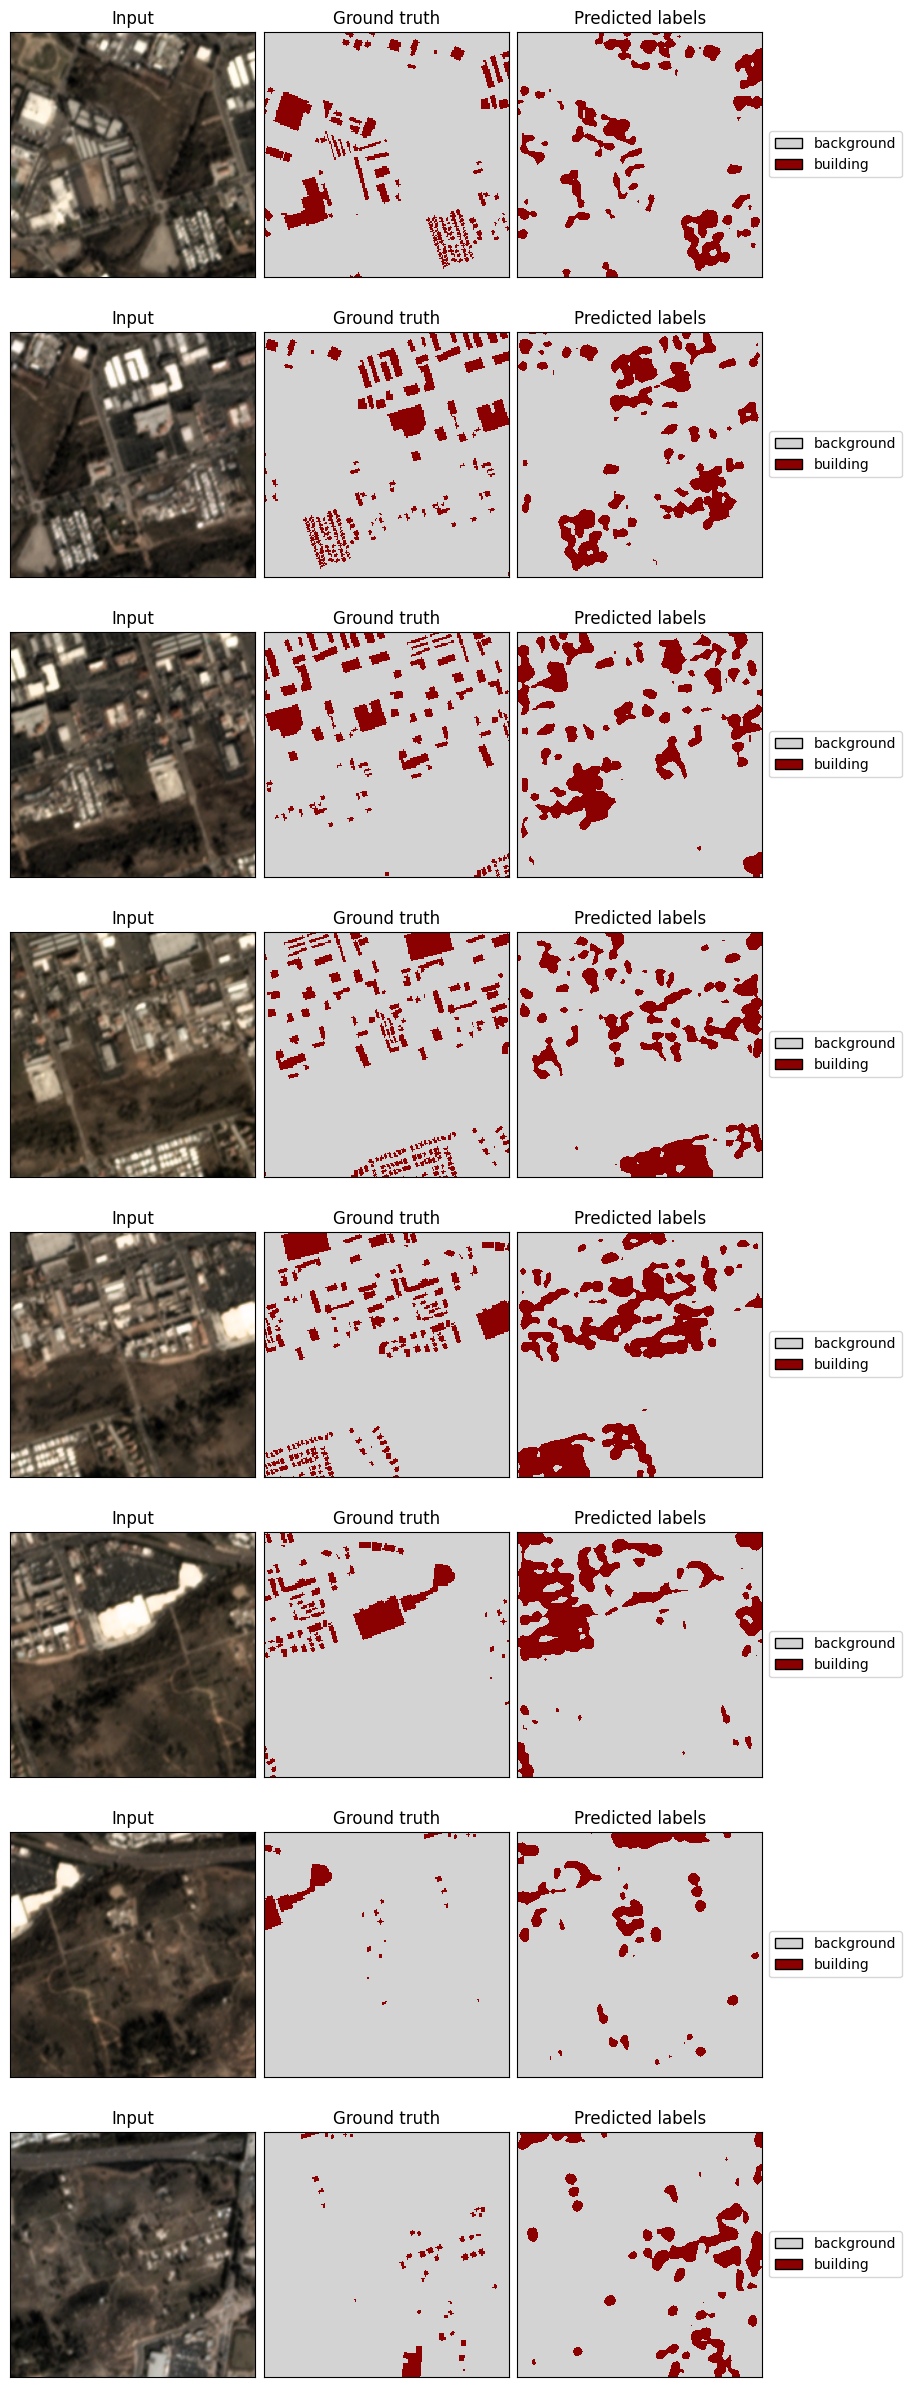

2024-04-09 20:19:03:rastervision.pytorch_learner.learner: INFO - Sample predictions written to ./train-demo/valid_preds.png.


In [19]:
learner.plot_predictions(split='valid', show=True)

Note the warning about `ModelConfig`. This is relevant when loading from from the bundle as we will see [below](#Using-model-bundles).

In [20]:
learner.save_model_bundle()

2024-04-09 20:19:03:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-04-09 20:19:03:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2024-04-09 20:19:03:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2024-04-09 20:19:04:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./train-demo/model-bundle.zip.


Zipping: 0it [00:00, ?it/s, model.onnx]

## Examine learner output

The trained model weights are saved at `data/train-demo/last-model.pth` as well as inside the model-bundle.

In [21]:
!tree "data/train-demo/"

data/train-demo/
├── checkpoints
├── dataloaders
│   ├── train.png
│   └── valid.png
├── last-model.pth
├── learner-config.json
├── log.csv
├── model-bundle.zip
├── tb-logs
│   └── events.out.tfevents.1722977627.e84-alienware-02.303298.0
└── valid_preds.png

3 directories, 8 files


## Using model-bundles

We can use the model-bundle to re-construct our `Learner` and then use it to make predictions.

In [22]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='data/train-demo/model-bundle.zip',
    output_dir='data/train-demo/',
    model=model,
)

2024-04-09 20:19:16:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2024-04-09 20:19:16:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpm5o2kvyl/model-bundle
2024-04-09 20:19:17:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpm5o2kvyl/model-bundle/model.pth


For next steps, see the ["Prediction and Evaluation" tutorial](./pred_and_eval_ss.ipynb).

We can also re-construct the `Learner` in order to continue training, perhaps on a different dataset. To do this, we pass in `train_ds` and `val_ds` and set `training=True`

In [23]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='data/train-demo/model-bundle.zip',
    output_dir='data/train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2024-04-09 20:19:20:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2024-04-09 20:19:20:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmplp5b8748/model-bundle
2024-04-09 20:19:21:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmplp5b8748/model-bundle/model.pth
2024-04-09 20:19:21:rastervision.pytorch_learner.learner: INFO - Building dataloaders
2024-04-09 20:19:21:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./train-demo/last-model.pth


Continue training:

In [24]:
learner.train(epochs=1)

2024-04-09 20:19:35:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 4
2024-04-09 20:19:35:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2024-04-09 20:19:35:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items
2024-04-09 20:19:35:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-04-09 20:19:36:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-04-09 20:19:36:rastervision.pytorch_learner.learner: INFO - epoch: 4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2024-04-09 20:19:40:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 4,
 'train_loss': 0.34853240847587585,
 'train_time': '0:00:02.899091',
 'val_loss': 0.4300776422023773,
 'avg_precision': 0.9265687465667725,
 'avg_recall': 0.8659200668334961,
 'avg_f1': 0.8952184319496155,
 'background_precision': 0.9700926542282104,
 'background_recall': 0.8847286701202393,
 'background_f1': 0.9254463315010071,
 'building_precision': 0.2373460829257965,
 'building_recall': 0.5680769085884094,
 'building_f1': 0.33480748534202576,
 'valid_time': '0:00:01.288514'}
